# Image Restoration/Inverse filters


In [1]:
import ECE1390_helpers
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread(os.path.relpath('../../Data//Pitt_Cathedral.jpg'), cv2.IMREAD_COLOR)


Bilateral Filter
So far, we have explained some filters which main goal is to smooth an input image. However, sometimes the filters do not only dissolve the noise, but also smooth away the edges. To avoid this (at certain extent at least), we can use a bilateral filter. In an analogous way as the Gaussian filter, the bilateral filter also considers the neighboring pixels with weights assigned to each of them. These weights have two components, the first of which is the same weighting used by the Gaussian filter. The second component takes into account the difference in intensity between the neighboring pixels and the evaluated one.

Median Filter
The median filter run through each element of the signal (in this case the image) and replace each pixel with the median of its neighboring pixels (located in a square neighborhood around the evaluated pixel).

Gaussian Filter
Probably the most useful filter (although not the fastest). Gaussian filtering is done by convolving each point in the input array with a Gaussian kernel and then summing them all to produce the output array.

Normalized Box Filter
This filter is the simplest of all! Each output pixel is the mean of its kernel neighbors ( all of them contribute with equal weights)

In [3]:
img2=ECE1390_helpers.add_pepper_noise(img,fraction=0.1)
img2=ECE1390_helpers.add_salt_noise(img2,fraction=0.1)

kernel = np.ones((5,5))/24
kernel[2,2]=0

img_filt = cv2.filter2D(img2,-1,kernel)
img_med = cv2.medianBlur(img2,3)
img_gauss = cv2.GaussianBlur(img2,(5,5),0,0)
img_bilat = cv2.bilateralFilter(img2,5,2,2,2)



Text(0.5, 1.0, 'Bilateral Filter')

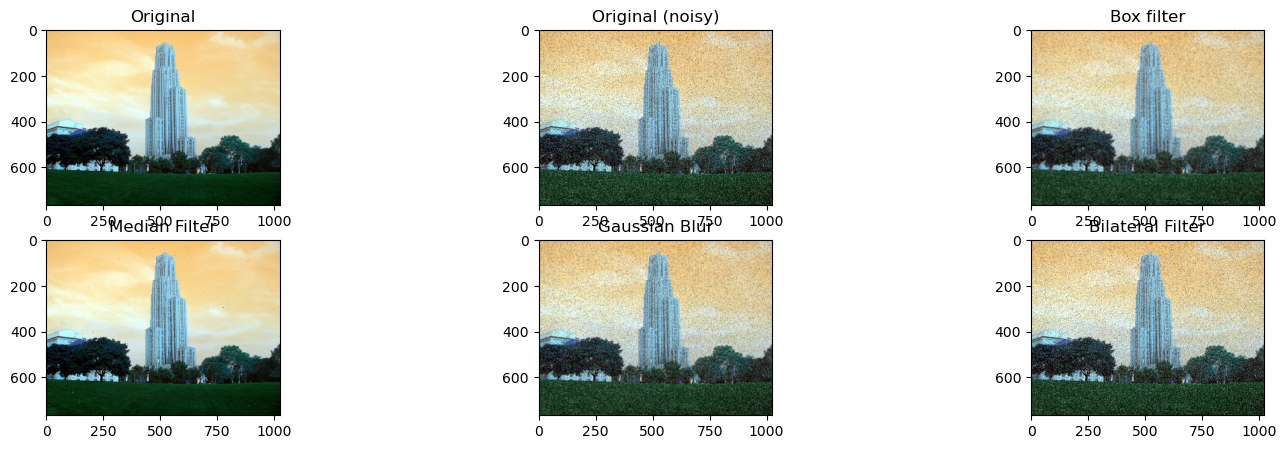

In [4]:

plt.figure(figsize=[18, 5])

plt.subplot(231); plt.imshow(img); plt.title('Original')
plt.subplot(232); plt.imshow(img2); plt.title('Original (noisy)')
plt.subplot(233); plt.imshow(img_filt); plt.title('Box filter')
plt.subplot(234); plt.imshow(img_med); plt.title('Median Filter')
plt.subplot(235); plt.imshow(img_gauss); plt.title('Gaussian Blur')
plt.subplot(236); plt.imshow(img_bilat); plt.title('Bilateral Filter')

https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html

In earlier chapters, we have seen many image smoothing techniques like Gaussian Blurring, Median Blurring etc and they were good to some extent in removing small quantities of noise. In those techniques, we took a small neighbourhood around a pixel and did some operations like gaussian weighted average, median of the values etc to replace the central element. In short, noise removal at a pixel was local to its neighbourhood.

There is a property of noise. Noise is generally considered to be a random variable with zero mean. Consider a noisy pixel, p=p0+n where p0 is the true value of pixel and n is the noise in that pixel. You can take large number of same pixels (say N) from different images and computes their average. Ideally, you should get p=p0 since mean of noise is zero.

You can verify it yourself by a simple setup. Hold a static camera to a certain location for a couple of seconds. This will give you plenty of frames, or a lot of images of the same scene. Then write a piece of code to find the average of all the frames in the video (This should be too simple for you now ). Compare the final result and first frame. You can see reduction in noise. Unfortunately this simple method is not robust to camera and scene motions. Also often there is only one noisy image available.

So idea is simple, we need a set of similar images to average out the noise. Consider a small window (say 5x5 window) in the image. Chance is large that the same patch may be somewhere else in the image. Sometimes in a small neighbourhood around it. What about using these similar patches together and find their average? For that particular window, that is fine. See an example image below:

The blue patches in the image looks the similar. Green patches looks similar. So we take a pixel, take small window around it, search for similar windows in the image, average all the windows and replace the pixel with the result we got. This method is Non-Local Means Denoising. It takes more time compared to blurring techniques we saw earlier, but its result is very good. More details and online demo can be found at first link in addition

In [49]:

# dst = cv.fastNlMeansDenoising(img,None,10,10,7,21)
# dst = cv.fastNlMeansDenoisingColored(img,None,10,10,7,21)

# Denoise 3rd frame considering all the 5 frames
# dst = cv.fastNlMeansDenoisingMulti(noisy, 2, 5, None, 4, 7, 35)
# dst = cv.fastNlMeansDenoisingColoredMulti(noisy, 2, 5, None, 4, 7, 35)

https://docs.opencv.org/3.4/de/d3c/tutorial_out_of_focus_deblur_filter.html


In [5]:
# https://www.researchgate.net/publication/332574579_Image_Processing_Course_Project_Image_Filtering_with_Wiener_Filter_and_Median_Filter

def wiener_filter(img,kernel,K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.float32(dummy)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel,s=img.shape)
    kernel = np.conj(kernel)/(np.abs(kernel)**2 + K)
    dummy = dummy*kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy


## [calcPSF]
def calcPSF(filterSize, R):
	h = np.zeros(filterSize, dtype=np.float32)
	point = (filterSize[1] // 2, filterSize[0] // 2)
	h = cv2.circle(h, point, R, 255, -1, 8)
	summa = np.sum(h)
	return (h / summa) 
## [calcPSF]

## [filter2DFreq]
def filter2DFreq(inputImg, H):
	planes = [inputImg.copy().astype(np.float32), 
		np.zeros(inputImg.shape, dtype=np.float32)]
	complexI = cv2.merge(planes)
	complexI = cv2.dft(complexI, flags=cv2.DFT_SCALE)

	planesH = [H.copy().astype(np.float32), 
		np.zeros(H.shape, dtype=np.float32)]
	complexH = cv2.merge(planesH)
	complexIH = cv2.mulSpectrums(complexI, complexH, 0)

	complexIH = cv2.idft(complexIH)
	planes = cv2.split(complexIH)
	return planes[0]
## [filter2DFreq]

## [calcWnrFilter]
def calcWnrFilter(input_h_PSF, nsr):
	h_PSF_shifted = np.fft.fftshift(input_h_PSF)
	planes = [h_PSF_shifted.copy().astype(np.float32), 
		np.zeros(h_PSF_shifted.shape, dtype=np.float32)]
	complexI = cv2.merge(planes)
	complexI = cv2.dft(complexI)
	planes = cv2.split(complexI)
	denom = np.power(np.abs(planes[0]), 2)
	denom += nsr 
	return cv2.divide(planes[0], denom) 
## [calcWnrFilter]

Text(0.5, 1.0, 'Recovered K=10')

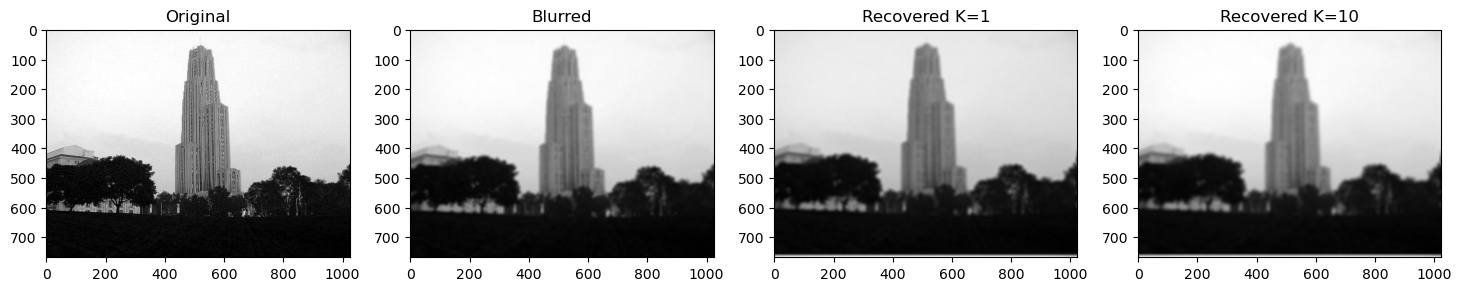

In [39]:
psf = calcPSF((15,15),7)

imgblur=cv2.filter2D(img[:,:,0],-1,psf)
Hw = calcWnrFilter(psf,10)
imR1=wiener_filter(imgblur,psf,1)
imR10=wiener_filter(imgblur,psf,10)

plt.figure(figsize=[18, 5])
plt.subplot(141); plt.imshow(img[:,:,0],cmap='gray'); plt.title("Original")
plt.subplot(142); plt.imshow(imgblur,cmap='gray'); plt.title("Blurred")
plt.subplot(143); plt.imshow(imR1,cmap='gray'); plt.title("Recovered K=1")
plt.subplot(144); plt.imshow(imR10,cmap='gray'); plt.title("Recovered K=10")

In [81]:
def calcWnrFilter_AR(img,k=(5,5)):
# This function implements a Weiner filter in the spatial domain using the Wiener-Hoft method

    # X = matrix of autoregressive relationships
    X = np.zeros((img.shape[0]*img.shape[1],k[0]*k[1]-1))
    cnt=0
    for i in range(0,k[0]):
        for j in range(0,k[1]):
            if not(i==2 and j==2):
                knl=np.zeros(k)
                knl[i,j]=1
                X[:,cnt]=np.ravel(cv2.filter2D(img,-1,knl))
                cnt+=1

    # coef is the AR coeffients for the k-size kernel
    coef=np.matmul(np.matmul(np.linalg.pinv(np.matmul(X.transpose(),X)),X.transpose()),np.ravel(img))

    # unpack the coef back into a kernel of size k
    kernel = np.zeros(k)
    cnt=0
    for i in range(0,k[0]):
        for j in range(0,k[1]):
            if not(i==2 and j==2):
                kernel[i,j]=coef[cnt]
                cnt+=1
            else:
                kernel[i,j]=1
    kernel=kernel/kernel.sum()

    return kernel



Text(0.5, 1.0, 'Recovered')

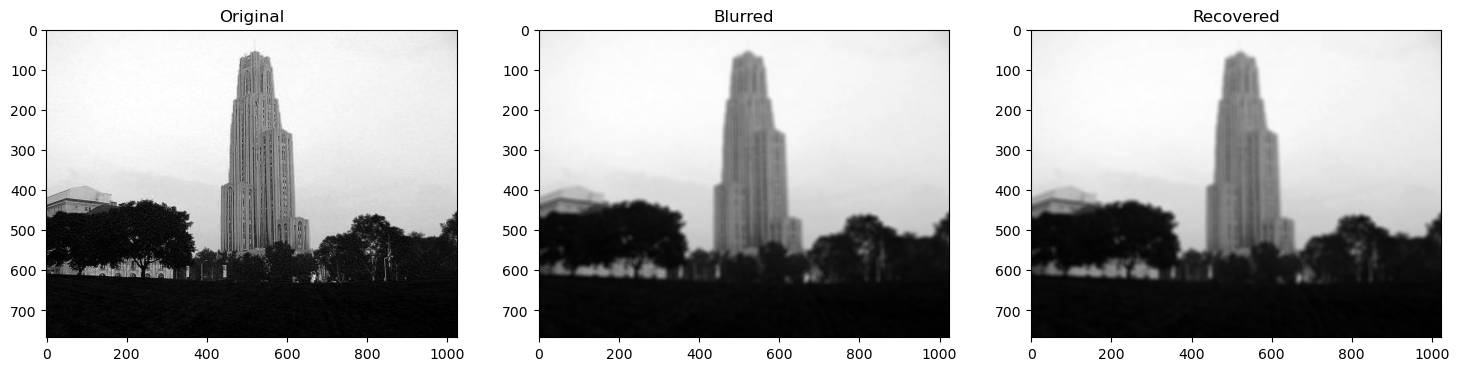

In [82]:


kernel = calcWnrFilter_AR(imgblur,k=(9,9))

plt.figure(figsize=[18, 5])
plt.subplot(131); plt.imshow(img[:,:,0],cmap='gray'); plt.title("Original")
plt.subplot(132); plt.imshow(imgblur,cmap='gray'); plt.title("Blurred")
plt.subplot(133); plt.imshow(cv2.filter2D(imgblur,-1,kernel),cmap='gray'); plt.title("Recovered")

Text(0.5, 1.0, 'Recovered')

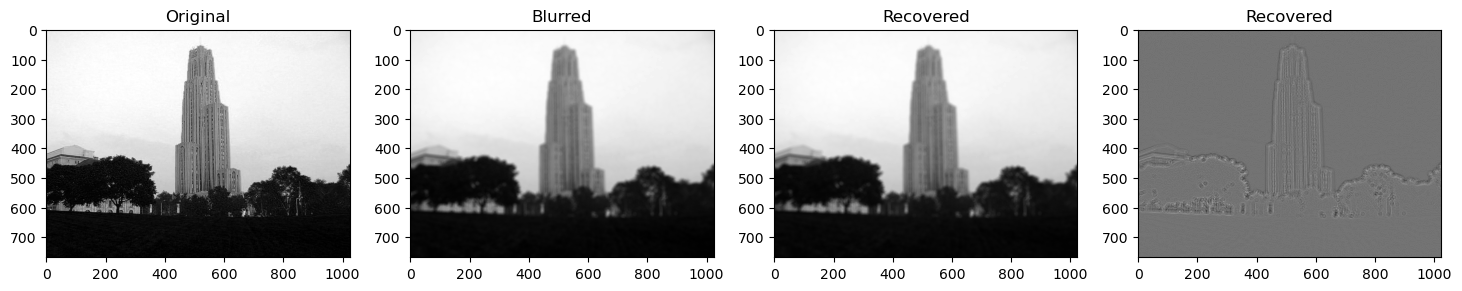

In [83]:
# Create the sharpening kernel 
kernel = np.array([[0, -1, 0], [-1, 9, -1], [0, -1, 0]]) 
kernel=kernel/kernel.sum()

sharpened_image = cv2.filter2D(imgblur, -1, kernel) 

#Sharpen the image using the Laplacian operator 
sharpened_image2 = cv2.Laplacian(imgblur, cv2.CV_64F)


plt.figure(figsize=[18, 5])
plt.subplot(141); plt.imshow(img[:,:,0],cmap='gray'); plt.title("Original")
plt.subplot(142); plt.imshow(imgblur,cmap='gray'); plt.title("Blurred")
plt.subplot(143); plt.imshow(sharpened_image,cmap='gray'); plt.title("Recovered")
plt.subplot(144); plt.imshow(sharpened_image2,cmap='gray'); plt.title("Recovered")

In [84]:
from skimage import color, data, restoration
from scipy.signal import convolve2d

psf = np.ones((5, 5)) / 25
imgN = convolve2d(img[:,:,0], psf, 'same')
imgN += 0.1 * img.std() * np.random.standard_normal(imgN.shape)
deconvolved_img = restoration.wiener(imgN,psf, 10,clip=False)

deconvolved, _ = restoration.unsupervised_wiener(imgN, psf,clip=False)

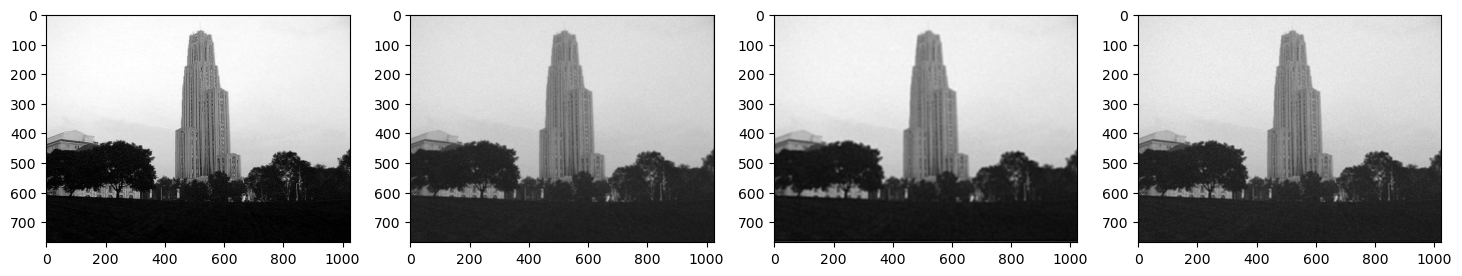

In [79]:
plt.figure(figsize=[18, 5])
plt.subplot(141); plt.imshow(img[:,:,0],cmap='gray')
plt.subplot(142); plt.imshow(imgN,cmap='gray')
plt.subplot(143); plt.imshow(deconvolved_img,cmap='gray')
plt.subplot(144); plt.imshow(deconvolved,cmap='gray')